In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
import matplotlib.pyplot as plt

In [2]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

(224, 225, 3)


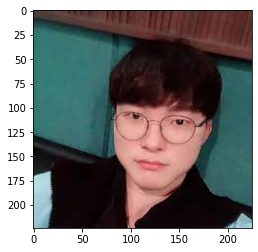

In [3]:
self_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/selfi1.jfif'  
self_orig = cv2.imread(self_path) 

print(self_orig.shape)
plt.imshow(cv2.cvtColor(self_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
segvalues, output = model.segmentAsPascalvoc(self_path)

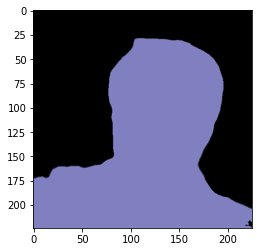

In [6]:
plt.imshow(output)
plt.show()

In [30]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [31]:
seg_color = colormap[15]

(224, 225)


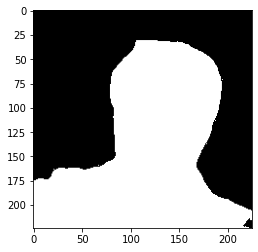

In [8]:
seg_map = np.all(output == seg_color, axis = -1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

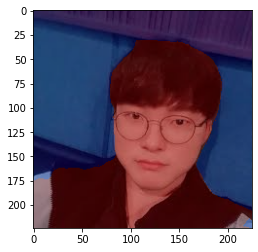

In [10]:
img_show = self_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

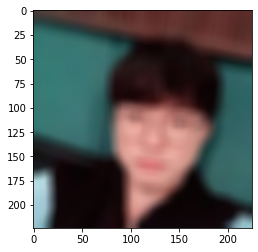

In [12]:
img_orig_blur = cv2.blur(self_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

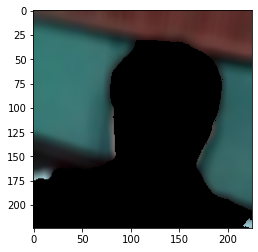

In [13]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

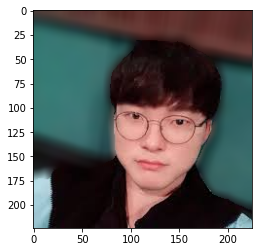

In [14]:
img_concat = np.where(img_mask_color==255, self_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 위 사진에서의 문제점

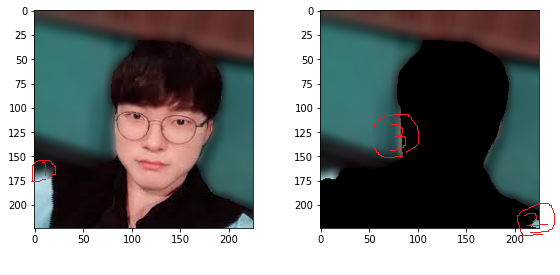

1. 사진 기준 왼쪽 어깨 부분이 사람으로 인식되지 않았다. 이로 인해 옷이 블러처리가 되었다.
2. 사진 기준 우측 하단 부분 또한 사람으로 인식되지 않았다. 
3. 사진의 화소가 다소 작아서 생기는 문제일 수도 있고, 모델의 성능 문제일 수도 있으나, 얼굴의 경계 부분에 대한 정확한 구분이 이루어지지 않았다.

## Chroma Key

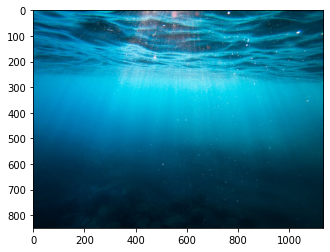

In [16]:
sea = cv2.imread('./images/sea.jpg')
plt.imshow(cv2.cvtColor(sea, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
sea = cv2.resize(sea, (self_orig.shape[1],self_orig.shape[0]))

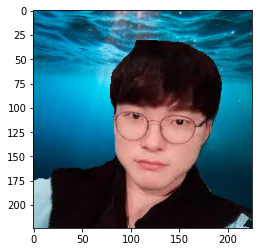

In [21]:
img_ChromaKey = np.where(img_mask_color==255, self_orig, sea)
plt.imshow(cv2.cvtColor(img_ChromaKey, cv2.COLOR_BGR2RGB))
plt.show()

- 배경을 블러처리 했을때 보다 크로마키 효과를 준 경우 인식이 잘 안된 부분이 보다 잘 드러난다. 사람의 머리 윗부분이 뽀죡하게 인식된 것을 확인할 수 있다.

## 고양이 모드

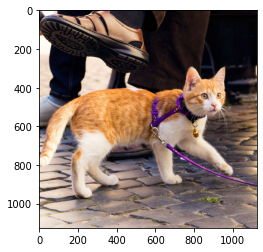

In [23]:
cat_path = './images/cat.jpg'
cat = cv2.imread(cat_path)
plt.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
segvalues, output = model.segmentAsPascalvoc(cat_path)

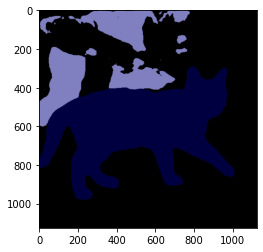

In [25]:
plt.imshow(output)
plt.show()

output에 클래스는 3개지만 color 값이 3개 이상이 들어갔기 때문에, 이는 필요없는 값으로 간주하고 고양이를 표현하는 색만 추출

In [62]:
color_list = dict()
for i in range(len(output)):
    for j in range(len(output[i])):
        try:
            if color_list[str(list(output[i][j]))]:
                color_list[str(list(output[i][j]))] += 1
        except:
            color_list[str(list(output[i][j]))] = 1


In [73]:
sorted(color_list.items(), key = lambda x : x[1], reverse = True)

[('[0, 0, 0]', 772243),
 ('[0, 0, 64]', 326332),
 ('[128, 128, 192]', 128226),
 ('[0, 0, 65]', 1521),
 ('[0, 0, 68]', 1277),
 ('[0, 0, 66]', 1146),
 ('[0, 0, 67]', 1054),
 ('[0, 0, 69]', 890),
 ('[129, 129, 193]', 720),
 ('[137, 137, 206]', 715),
 ('[127, 127, 191]', 566),
 ('[128, 128, 191]', 486),
 ('[0, 0, 63]', 481),
 ('[130, 130, 195]', 459),
 ('[129, 129, 194]', 415),
 ('[0, 0, 2]', 373),
 ('[137, 137, 205]', 369),
 ('[133, 133, 199]', 363),
 ('[132, 132, 198]', 361),
 ('[0, 0, 1]', 359),
 ('[135, 135, 203]', 353),
 ('[128, 128, 193]', 345),
 ('[0, 0, 62]', 335),
 ('[0, 0, 70]', 327),
 ('[131, 131, 196]', 311),
 ('[131, 131, 197]', 306),
 ('[134, 134, 201]', 301),
 ('[136, 136, 204]', 300),
 ('[0, 0, 71]', 299),
 ('[0, 0, 61]', 289),
 ('[135, 135, 202]', 283),
 ('[0, 0, 58]', 262),
 ('[0, 0, 3]', 256),
 ('[130, 130, 194]', 246),
 ('[0, 0, 55]', 244),
 ('[0, 0, 60]', 238),
 ('[0, 0, 5]', 237),
 ('[0, 0, 59]', 235),
 ('[0, 0, 7]', 219),
 ('[0, 0, 57]', 212),
 ('[0, 0, 56]', 212),
 

[0,0,0]은 background이고, [128, 128, 192]는 사람이기 때문에  [0, 0, 64]를 cat이라고 판단

In [74]:
seg_color = [0, 0, 64]

In [26]:
segvalues

{'class_ids': array([ 0,  8, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [29]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
LABEL_NAMES[8]

'cat'

background, cat, person 3가지 class가 검출

(1125, 1125)


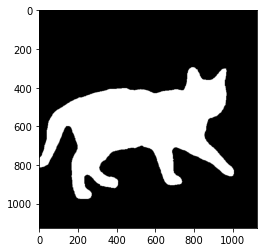

In [75]:
seg_map = np.all(output == seg_color, axis = -1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

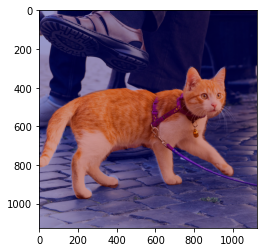

In [76]:
img_show = cat.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

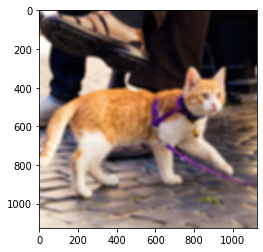

In [82]:
img_orig_blur = cv2.blur(cat, (20, 20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

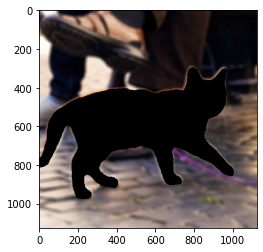

In [83]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

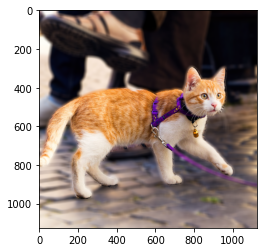

In [84]:
img_concat = np.where(img_mask_color==255, cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 해결방안

1. Segmentation으로 검출한 인물사진의 부분에 더해 과거 아이폰에 추가되었던 트루뎁스 카메라나 삼성의 뎁스비전 카메라와 같이 사진의 심도(depth)값을 추가로 얻을 수 있다면, 검출한 부분과 depth값을 더해 보다 정교한 mask를 얻을 수 있을 것이다.

2. 위 방식은 하드웨어적인 해결방안이라면 기존에 촬영된 2D image의 Depth를 estimate 할 수 있는  struct2Depth 와 같은 기술을 위와 같은 방식으로 mask의 정확도를 검증하는 방식으로 사용한다면 보다 정확한 결과를 얻을 수 있을 것이다.

3. 사람의 얼굴을 구분하는 경우는 최근 많이 볼 수 있는 체온측정 기술을 활용하는 방법도 있을 것 같다. 사람 얼굴의 온도는 일반적인 공기의 온도보다 훨씬 높기 때문에 우리가 보는 체온측정 카메라의 경우 얼굴부분만 붉은 색으로 나오는 것을 확인할 수 있다. 이는 물론 머리카락으로 덮혀져있거나 무언가로 가려져 있는 부분에 대해서는 정확도가 높지 않을 수는 있지만, mask의 정밀도를 높이기 위한 방법으로는 충분하 사용을 고려할 수 있을 것이다.

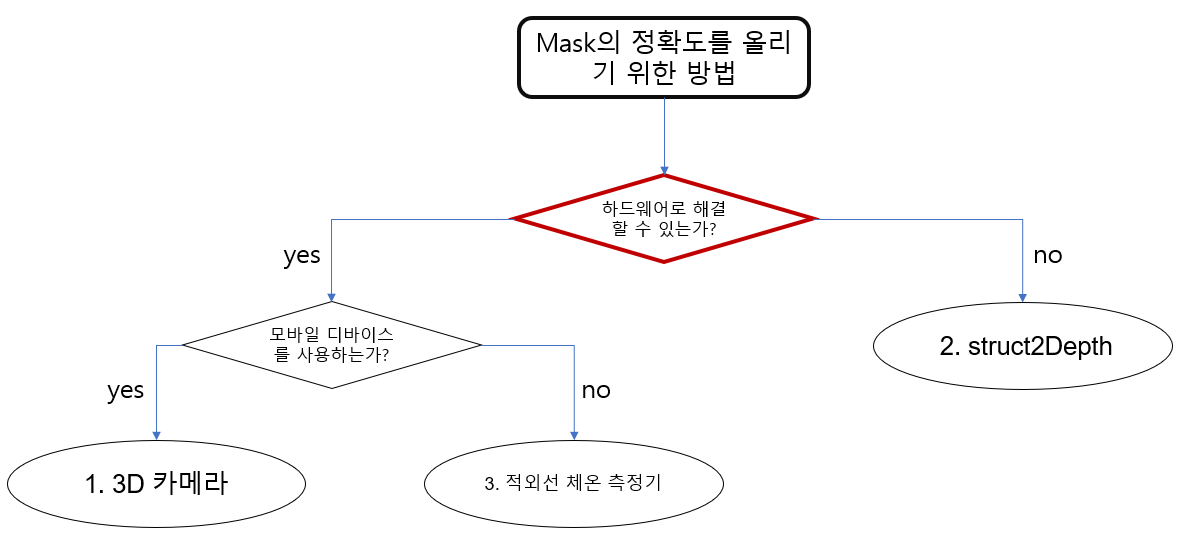